In [18]:
import pandas as pd
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt 
import datetime as dt
import re

In [19]:
data = pd.read_csv('matala2_cosmetics_2019-Nov.csv')
data.head()
data.info()

c:\Users\yona\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   event_time     1048575 non-null  object
 1   event_type     1048575 non-null  object
 2   product_id     1048575 non-null  int64 
 3   category_id    1048575 non-null  int64 
 4   category_code  16715 non-null    object
 5   brand          602451 non-null   object
 6   price          1048575 non-null  object
 7   user_id        1048575 non-null  int64 
 8   user_session   1048357 non-null  object
dtypes: int64(3), object(6)
memory usage: 72.0+ MB


In [20]:
data = data[data['user_session'].notnull()]

In [21]:
data['event_time'] = data['event_time'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048357 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   event_time     1048357 non-null  datetime64[ns]
 1   event_type     1048357 non-null  object        
 2   product_id     1048357 non-null  int64         
 3   category_id    1048357 non-null  int64         
 4   category_code  16715 non-null    object        
 5   brand          602332 non-null   object        
 6   price          1048357 non-null  object        
 7   user_id        1048357 non-null  int64         
 8   user_session   1048357 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 80.0+ MB



**סעיף 1**

In [22]:
data = data.sort_values(['user_session', 'event_time'], ascending=[True, True])
data['duration_to_next_event'] = data.groupby('user_session')['event_time'].diff(-1).dt.total_seconds().fillna(0)
data.loc[data.groupby('user_session').tail(1).index, 'duration_to_next_event'] = 0
data['duration_to_next_event'] = data['duration_to_next_event'].abs()

**סעיף 2**

In [23]:
data = data.sort_values(['user_id', 'event_time'], ascending=[True, True])
data['diff_for_funnel'] = data.groupby('user_id')['event_time'].diff()
data['funnel_number'] = (data['diff_for_funnel'] > pd.Timedelta(days=5)).groupby(data['user_id']).cumsum()
data['funnel_number'] = data['funnel_number'].fillna(0) + 1

**סעיף 3**

In [24]:
data['index_in_funnel'] = data.groupby(['user_id','funnel_number'])['user_session'].transform('nunique')

**סעיף 4**

לגבי הסעיף הזה שמתי לב כשאני מנסה להעיף את התבים שהם לא מספר בעמודה מחיר הפקודה היה מוחק לי חלק מהערכים התקינים 
 אז בחרתי לייצר דאטה פראם חדש שכוללת רק את הערכים הלא תקינים ,לעיף את התבים שהם לא מספר ואז להחליף את השורות האלה בדאטה פראם המקורי עם השורות של הדאטה פראם שעבדתי עליו.


In [25]:
data_with_letter_in_price = data[data['price'].str.contains(r'[^\d.]', na=False)]
data_with_letter_in_price['price'] = data_with_letter_in_price['price'].str.extract(r'(\d+\.?\d*)', expand=False)
data.update(data_with_letter_in_price)
data['price'] = data['price'].astype(float)

<ipython-input-25-ba6a850d3df2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_letter_in_price['price'] = data_with_letter_in_price['price'].str.extract(r'(\d+\.?\d*)', expand=False)


**סעיף 5**

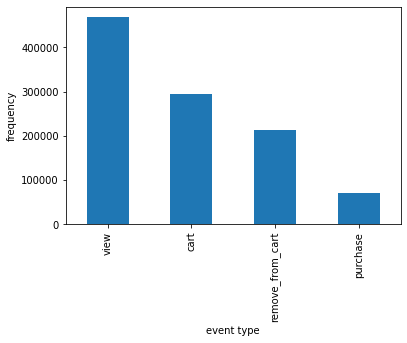

In [26]:
data['event_type'].value_counts().plot(kind='bar', xlabel='event type', ylabel='frequency')
plt.show()

**סעיף 6**

In [27]:
#CREATE A NEW DATAFRAME
session_data = data.loc[:, ['user_id', 'user_session', 'funnel_number','index_in_funnel']].drop_duplicates()


In [28]:
#COUNT num of event for session
datacounts = data.groupby('user_session')['event_time'].count()
session_data ['num_of_event'] = session_data ['user_session'].map(datacounts)

In [29]:
#TIME of event for session
datatime = data.groupby('user_session')['event_time'].apply(lambda x: x.max() - x.min())
session_data ['connection_time'] = session_data ['user_session'].map(datatime)


In [30]:
#PRODUCT ID view for session
view_products_list = data[data['event_type'] == 'view'].groupby('user_session')['product_id'].agg(list)
session_data['list_of_viewed'] = session_data ['user_session'].map(view_products_list)

In [31]:
#PRODUCT ID cart for session
cart_products_list = data[data['event_type'] == 'cart'].groupby('user_session')['product_id'].agg(list)
session_data['list_of_added_to_cart'] = session_data ['user_session'].map(cart_products_list)

In [32]:
#PRODUCT ID purchase for session
purchases_products_list = data[data['event_type'] == 'purchase'].groupby('user_session')['product_id'].agg(list)
session_data['list_of_purchased'] = session_data ['user_session'].map(purchases_products_list)

In [33]:
session_data

,user_id,user_session,funnel_number,index_in_funnel,num_of_event,connection_time,list_of_viewed,list_of_added_to_cart,list_of_purchased
437209,1120748.0,d0484d94-7ac1-44e8-a310-2360da11ad9d,1.0,1.0,1,0 days 00:00:00,[5240.0],NaN,NaN
697519,10079204.0,f873d16b-4efa-4e92-81be-92948aef2ff5,1.0,1.0,4,0 days 00:02:56,NaN,"[5614842.0, 5766379.0]","[5766379.0, 5614842.0]"
331383,10521214.0,25d2d492-d688-4baa-adf1-7296dbdd663e,1.0,1.0,3,0 days 00:02:13,"[5713294.0, 5713295.0, 5713294.0]",NaN,NaN
462864,11274156.0,0c778a88-4700-4e8b-becb-3371ec28ea79,1.0,2.0,2,0 days 00:00:20,[5899834.0],[5809910.0],NaN
463230,11274156.0,7bcf0afd-33ab-49ca-bd55-9c11a817b3d2,1.0,2.0,1,0 days 00:00:00,[5649179.0],NaN,NaN
...,...,...,...,...,...,...,...,...,...
1048392,568926337.0,1325e7ce-c706-4253-99ad-1eaf9cfe70ee,1.0,1.0,1,0 days 00:00:00,[5861591.0],NaN,NaN
1048385,568926338.0,09994a71-7ac0-415a-9f49-d8df982ac9dd,1.0,1.0,1,0 days 00:00:00,[5799891.0],NaN,NaN
1048471,568926409.0,0e45dae2-2e7a-4919-9ec2-cbecd4354a02,1.0,1.0,1,0 days 00:00:00,[5881598.0],NaN,NaN
1048462,568926576.0,de462037-13f3-4217-9b8e-408e1ba014d9,1.0,1.0,1,0 days 00:00:00,[5876382.0],NaN,NaN
